Epoch 0: Autoencoder Loss: 0.6827763319015503, Generator Loss: [0.6574733], Discriminator Loss: 21.067374408245087


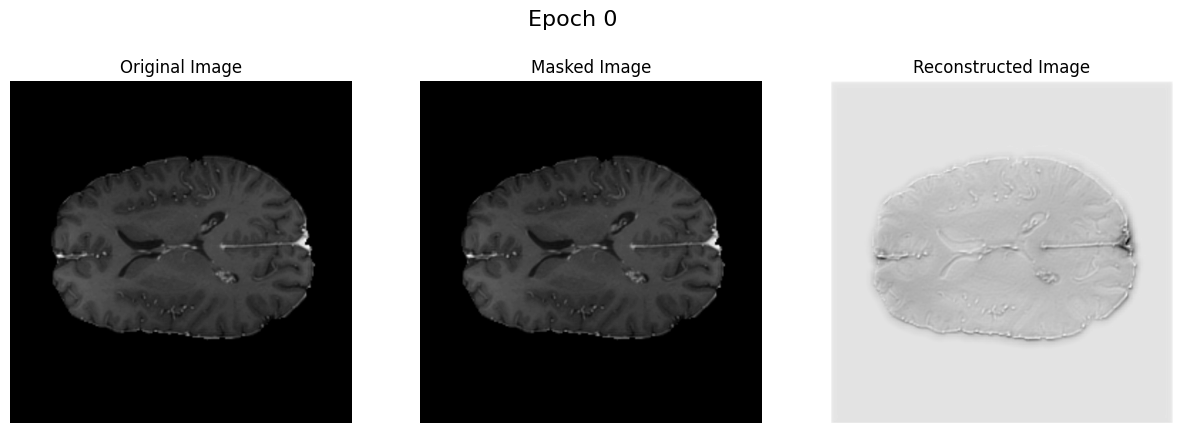

C:\Users\priya\anaconda3\envs\anacondagpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 50: Autoencoder Loss: 0.0831347331404686, Generator Loss: [6.328344], Discriminator Loss: 0.004345852677943185


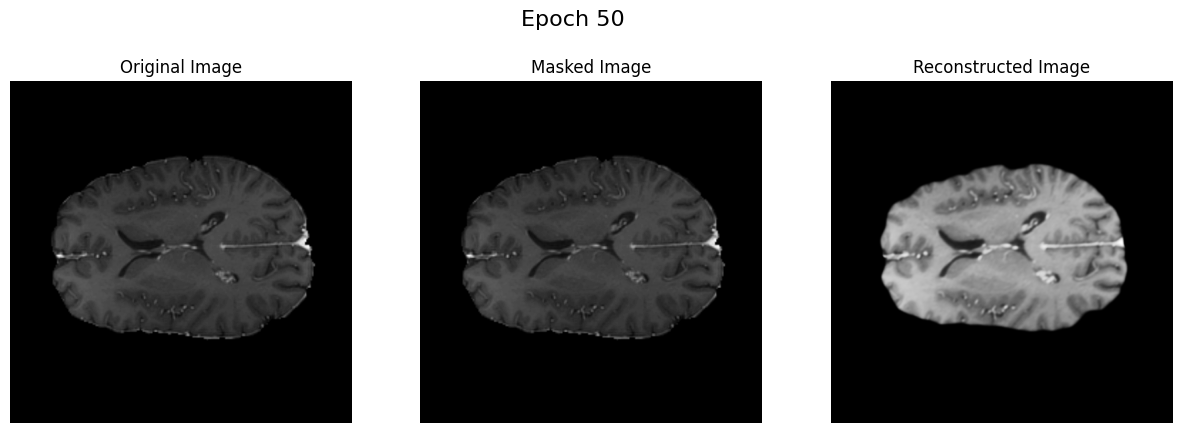

Epoch 100: Autoencoder Loss: 0.0522892028093338, Generator Loss: [1.3431706], Discriminator Loss: 0.24172969264327548


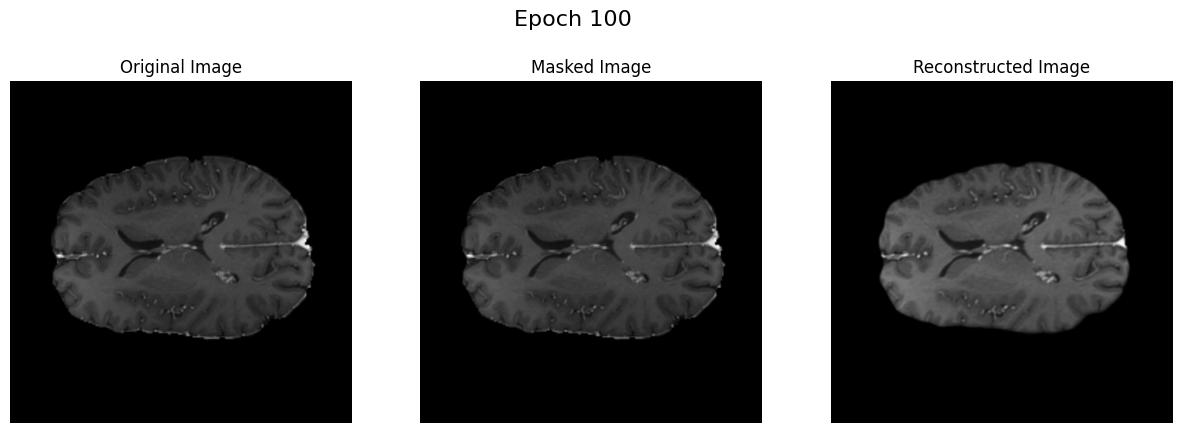

Epoch 150: Autoencoder Loss: 0.05470060929656029, Generator Loss: [3.1159947], Discriminator Loss: 0.044698966667056084


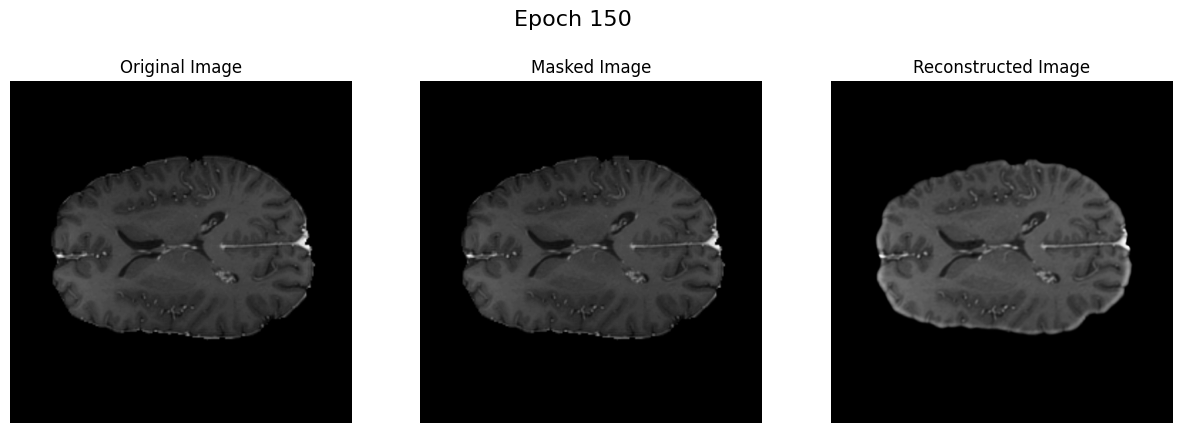

Epoch 200: Autoencoder Loss: 0.002469815080985427, Generator Loss: [0.8209362], Discriminator Loss: 1.1455473899841309


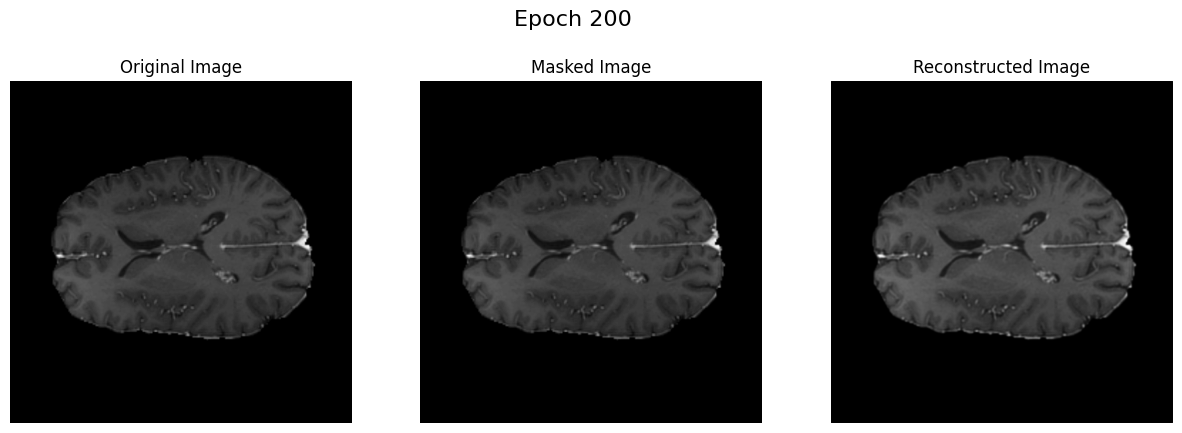

Epoch 250: Autoencoder Loss: 0.0078982999548316, Generator Loss: [1.6923635], Discriminator Loss: 0.6419079005718231


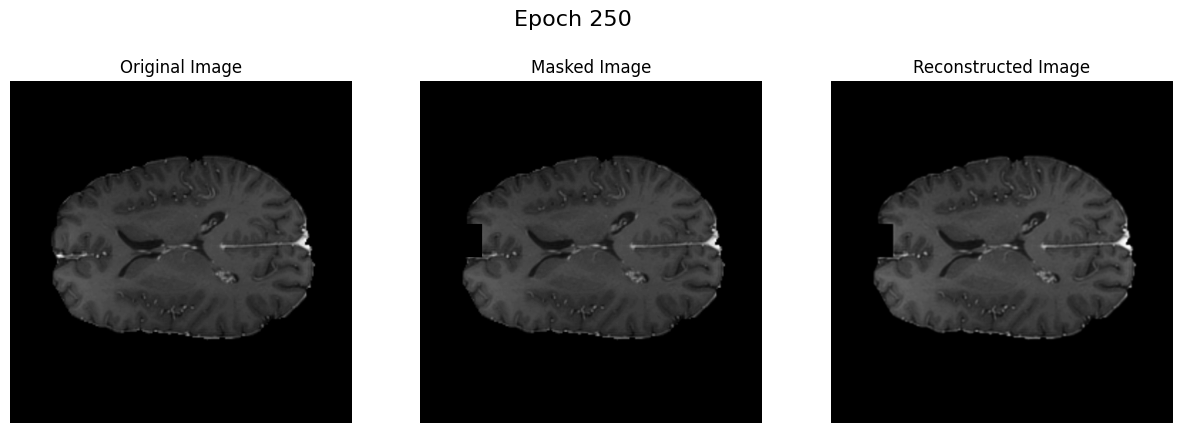

Epoch 300: Autoencoder Loss: 0.0022654898930341005, Generator Loss: [2.4592228], Discriminator Loss: 0.23417435586452484


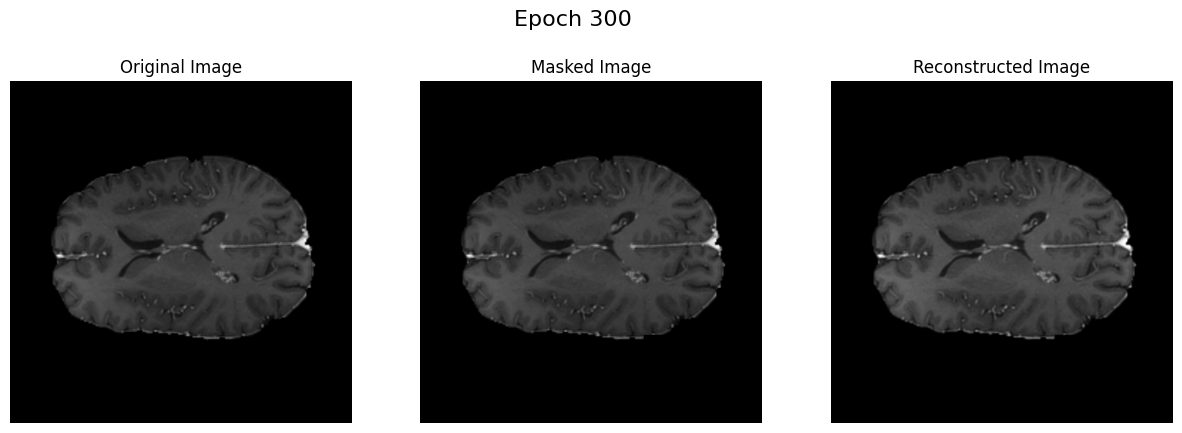

Epoch 350: Autoencoder Loss: 0.010863978415727615, Generator Loss: [3.4341023], Discriminator Loss: 0.19315367564558983


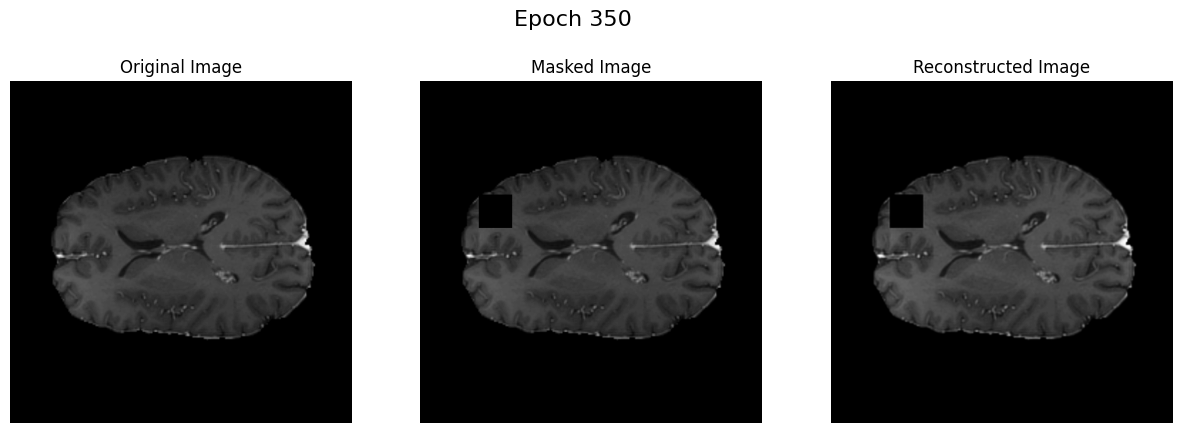

Epoch 400: Autoencoder Loss: 0.010232323780655861, Generator Loss: [4.154989], Discriminator Loss: 0.15168049931526184


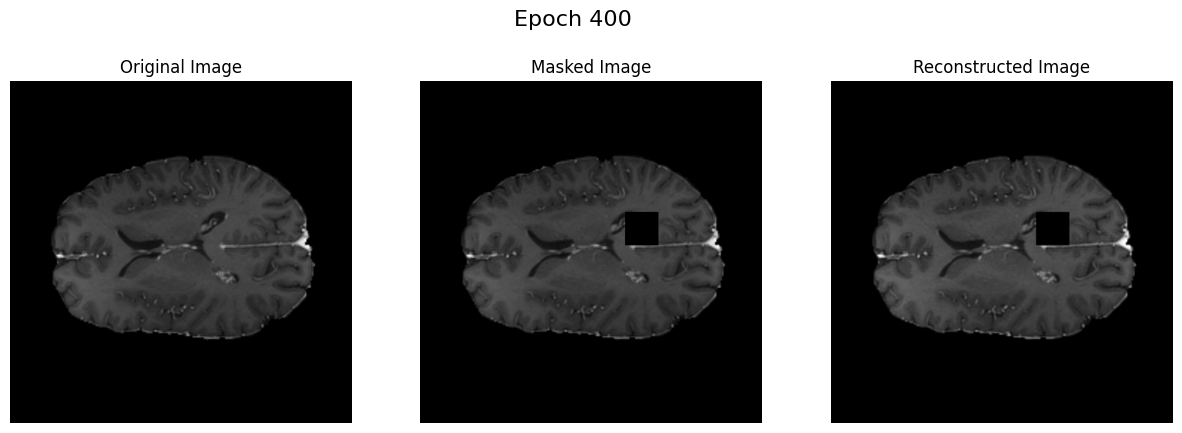

Epoch 450: Autoencoder Loss: 0.010448718443512917, Generator Loss: [2.1910934], Discriminator Loss: 0.31130242347717285


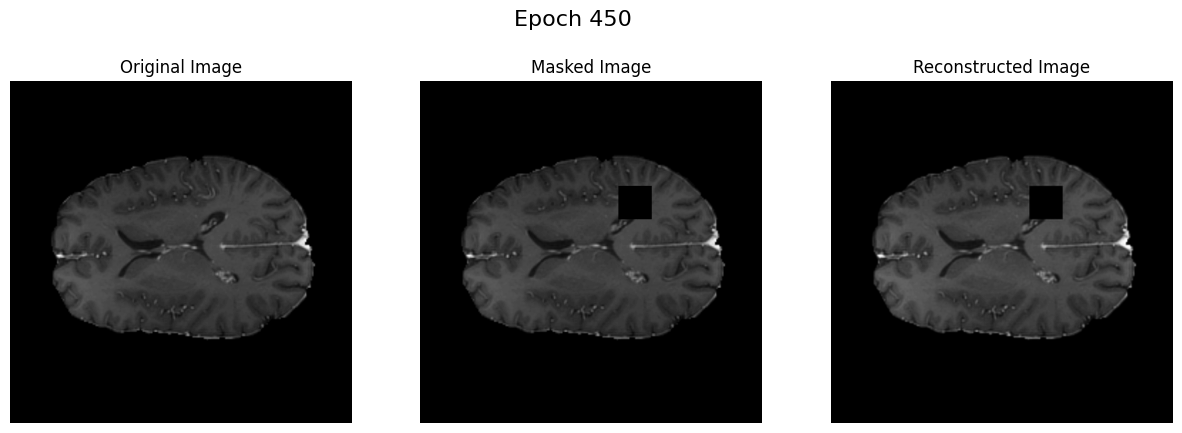

Epoch 500: Autoencoder Loss: 0.008786129765212536, Generator Loss: [3.0272357], Discriminator Loss: 0.16377684473991394


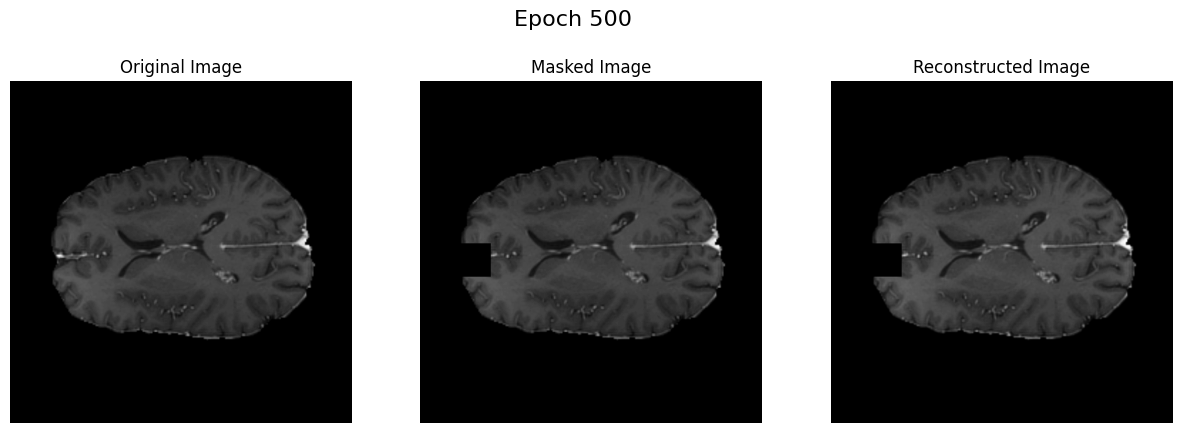

Epoch 550: Autoencoder Loss: 0.001954235602170229, Generator Loss: [3.6351738], Discriminator Loss: 0.13274036720395088


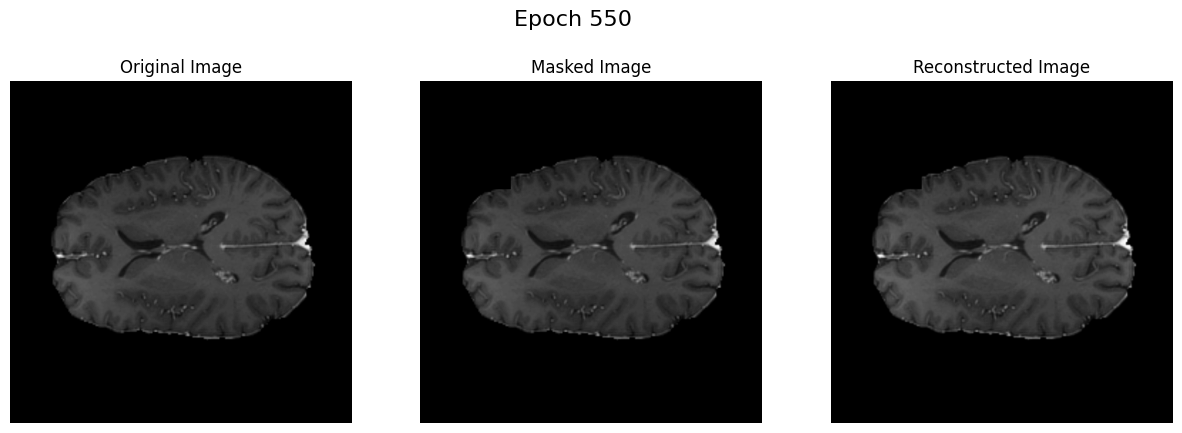

Epoch 600: Autoencoder Loss: 0.0044677904807031155, Generator Loss: [3.010327], Discriminator Loss: 0.07038154825568199


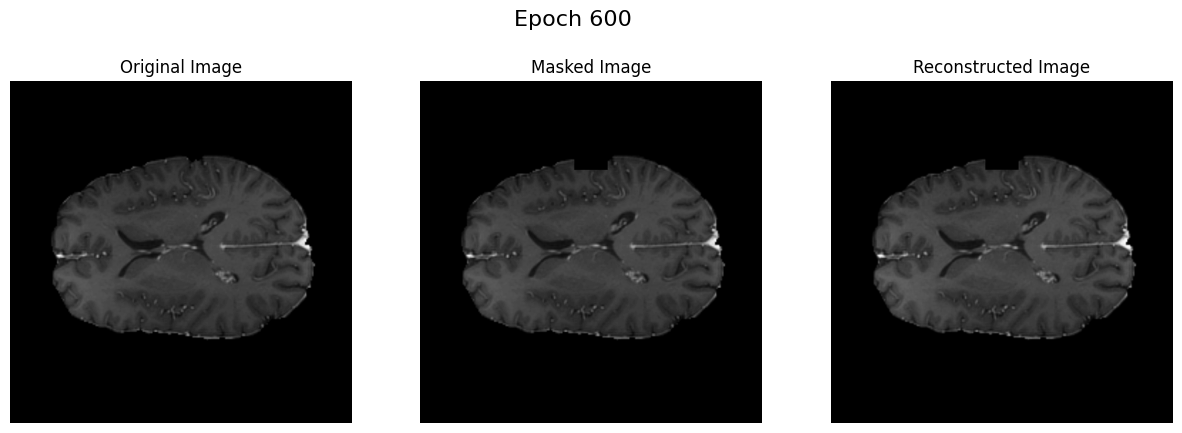

Epoch 650: Autoencoder Loss: 0.0004953559837304056, Generator Loss: [4.0761814], Discriminator Loss: 0.06562795117497444


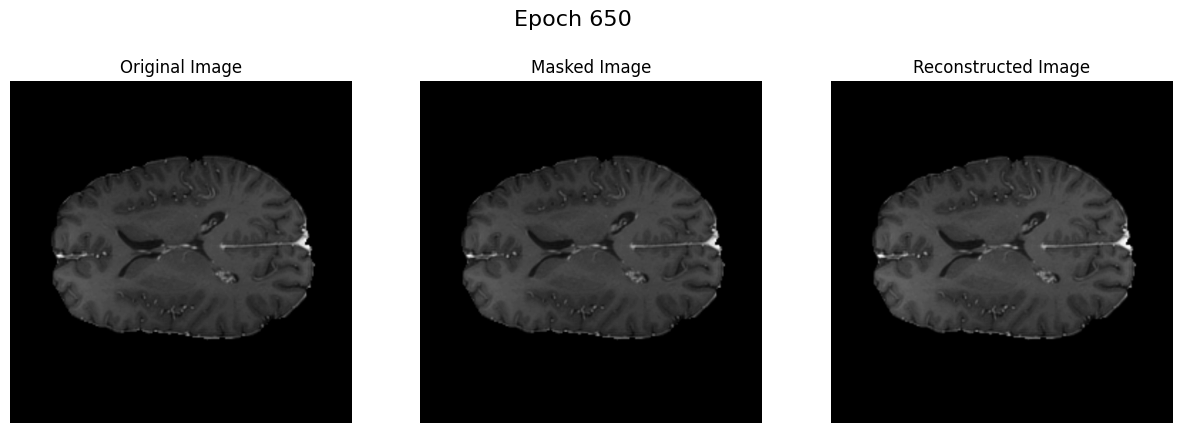

Epoch 700: Autoencoder Loss: 0.00850608479231596, Generator Loss: [5.960909], Discriminator Loss: 0.1554164495319128


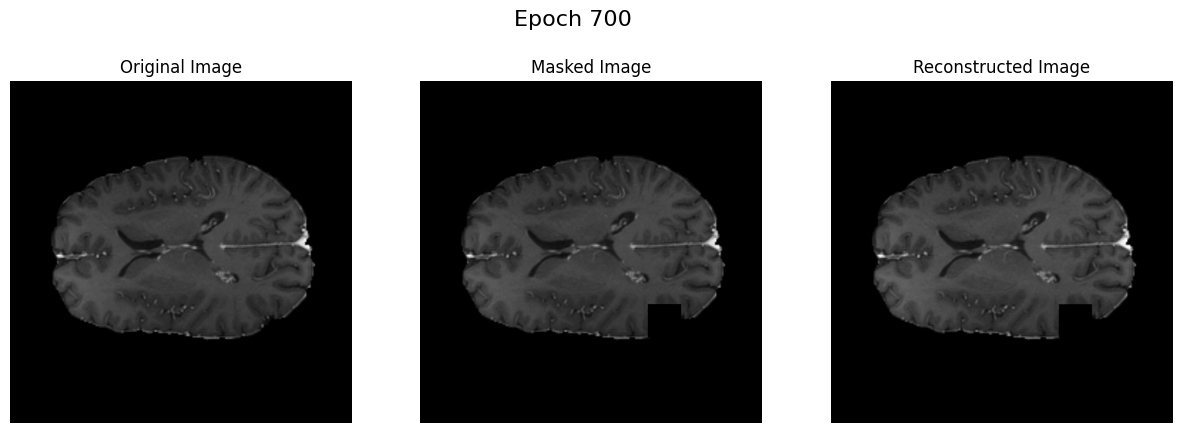

Epoch 750: Autoencoder Loss: 0.01000614557415247, Generator Loss: [2.8681371], Discriminator Loss: 0.14109183102846146


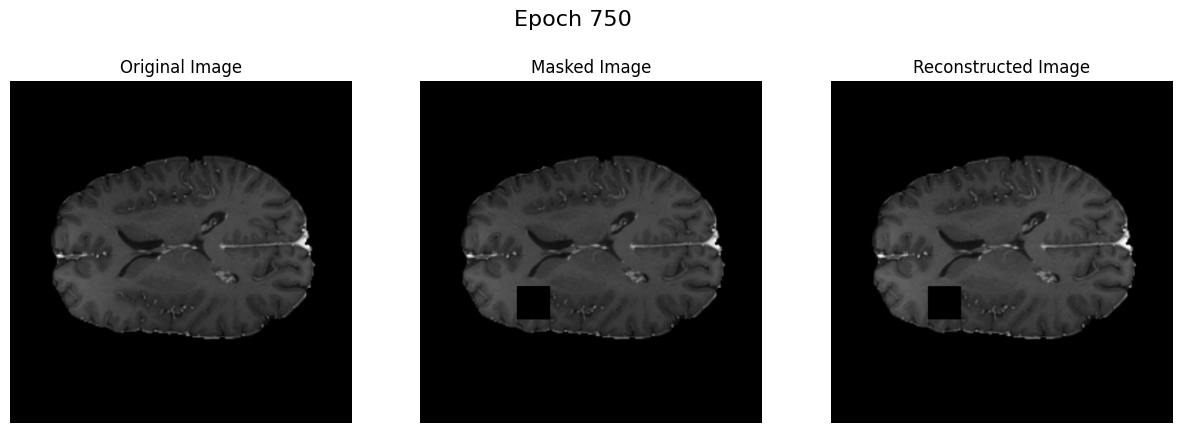

Epoch 800: Autoencoder Loss: 0.0004780749441124499, Generator Loss: [3.4851959], Discriminator Loss: 0.06271401606500149


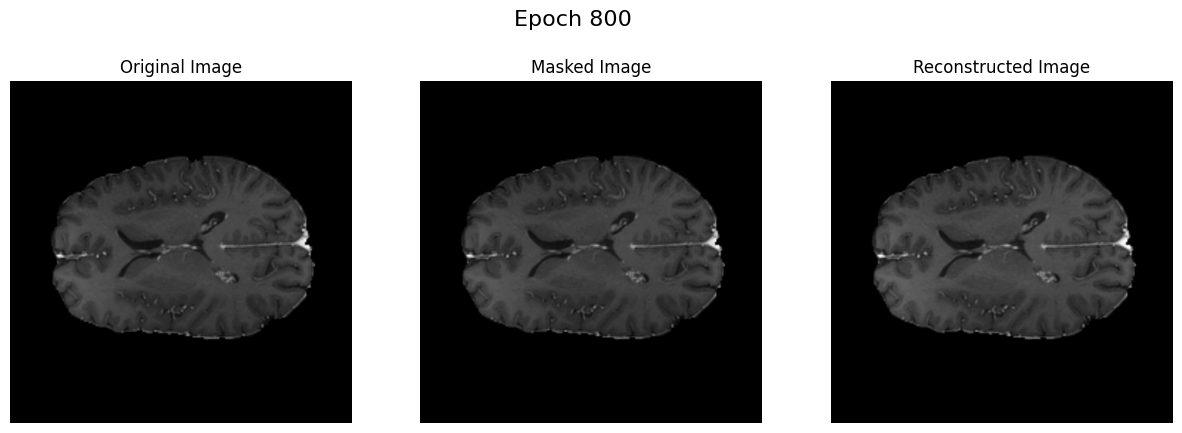

Epoch 850: Autoencoder Loss: 0.00035418293555267155, Generator Loss: [4.2513986], Discriminator Loss: 0.04149960167706013


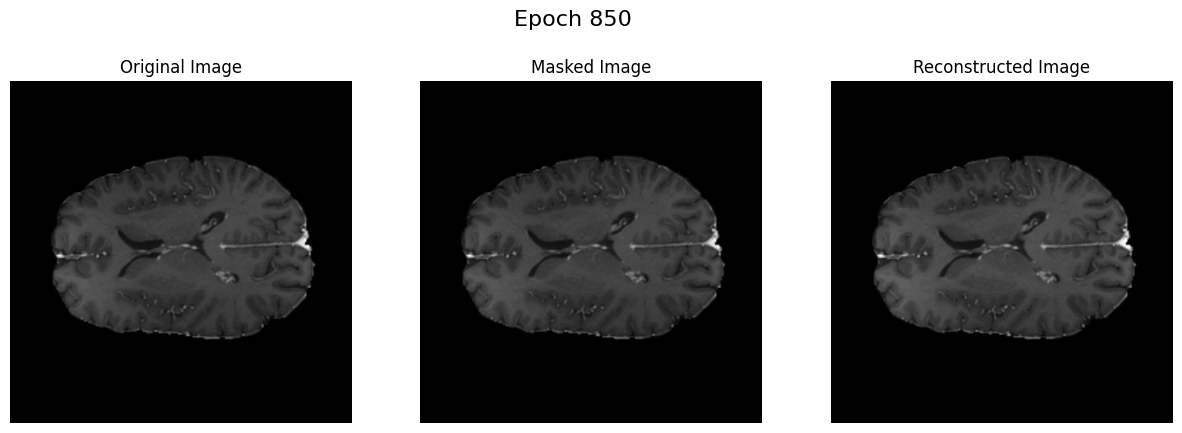

Epoch 900: Autoencoder Loss: 0.009748516604304314, Generator Loss: [4.207112], Discriminator Loss: 0.05072375573217869


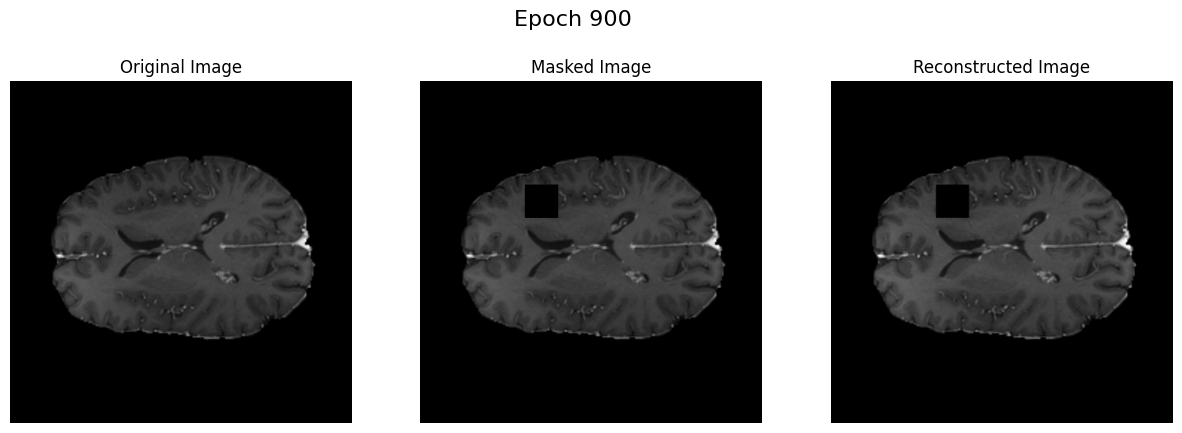

Epoch 950: Autoencoder Loss: 0.003788959002122283, Generator Loss: [4.5625806], Discriminator Loss: 0.038594113662838936


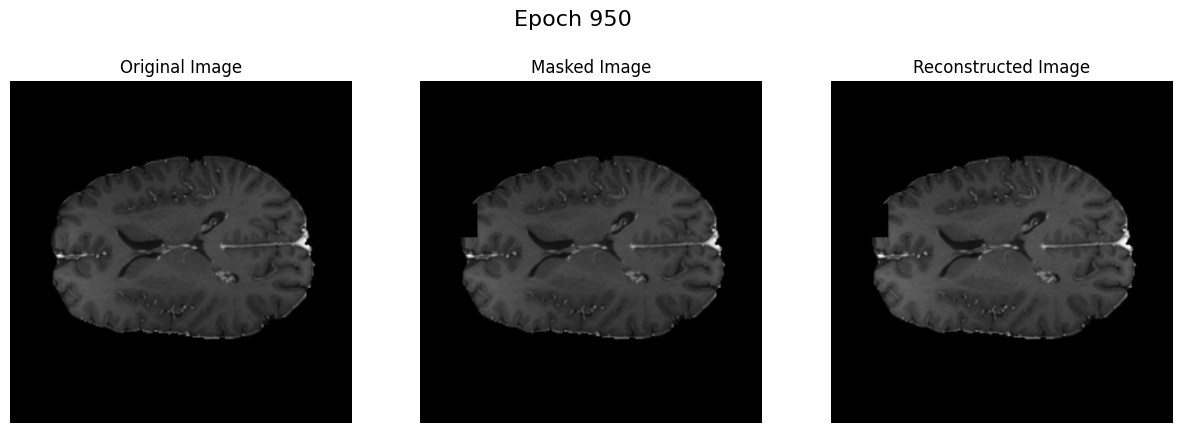

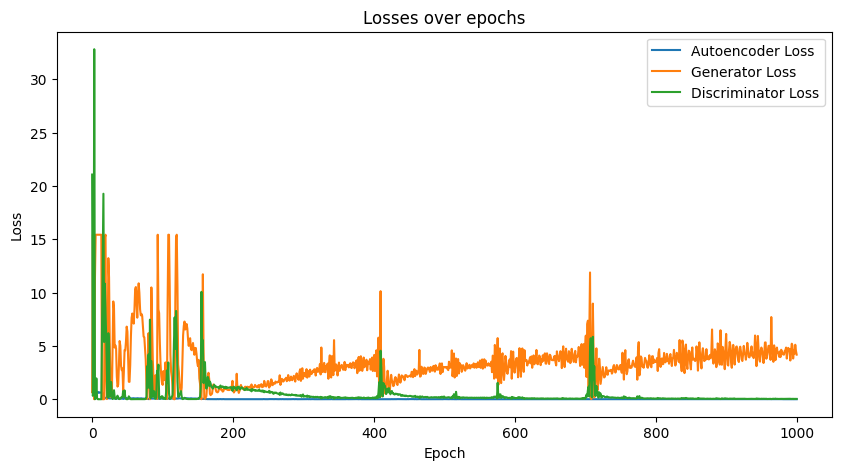

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import ssim

# Attention Block
def attention_block(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, kernel_size=(1, 1))(x)
    phi_g = layers.Conv2D(inter_channels, kernel_size=(1, 1))(g)
    
    concat_xg = layers.add([theta_x, phi_g])
    relu_xg = layers.Activation('relu')(concat_xg)
    
    psi = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(relu_xg)
    psi = layers.UpSampling2D(size=(x.shape[1] // psi.shape[1], x.shape[2] // psi.shape[2]))(psi)
    
    return layers.multiply([x, psi])

# Encoder
def encoder(inputs):
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    
    return conv3, conv2, conv1

# Decoder with Skip Connections and Attention
def decoder(encoded, conv2, conv1):
    up1 = layers.UpSampling2D((2, 2))(encoded)
    attention1 = attention_block(conv2, up1, 128)
    concat1 = layers.concatenate([up1, attention1])
    
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    
    up2 = layers.UpSampling2D((2, 2))(conv4)
    attention2 = attention_block(conv1, up2, 64)
    concat2 = layers.concatenate([up2, attention2])
    
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    return outputs

# GAN Discriminator
def discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    conv1 = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    conv1 = layers.LeakyReLU(alpha=0.2)(conv1)
    conv2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(conv1)
    conv2 = layers.LeakyReLU(alpha=0.2)(conv2)
    flatten = layers.Flatten()(conv2)
    dense = layers.Dense(1, activation='sigmoid')(flatten)
    
    return models.Model(inputs, dense, name="discriminator")

# Autoencoder-GAN Model
def autoencoder_gan(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    encoded, conv2, conv1 = encoder(inputs)
    
    # Decoder
    outputs = decoder(encoded, conv2, conv1)
    
    # Autoencoder Model
    autoencoder = models.Model(inputs, outputs, name="autoencoder")
    
    # Discriminator Model
    discriminator_model = discriminator(input_shape)

    return autoencoder, discriminator_model

# Custom loss function: Combined SSIM and MSE
def custom_loss(y_true, y_pred):
    ssim_loss = tf.reduce_mean(1 - ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.8 * ssim_loss + 0.2 * mse_loss

# Compile Autoencoder Model
input_shape = (512, 512, 1)
autoencoder, discriminator_model = autoencoder_gan(input_shape)
autoencoder.compile(optimizer='adam', loss=custom_loss)
discriminator_model.compile(optimizer='adam', loss='binary_crossentropy')

# Masking Function
def apply_random_mask(image, mask_size=50):
    masked_image = np.copy(image)
    x = np.random.randint(0, image.shape[0] - mask_size)
    y = np.random.randint(0, image.shape[1] - mask_size)
    masked_image[x:x+mask_size, y:y+mask_size] = 0
    return masked_image

# Load and preprocess data
clean_brain_image = tf.image.decode_png(tf.io.read_file(r"C:\Users\priya\Documents\DL project\61_processed_image.png"), channels=1)
clean_brain_image = tf.image.resize(clean_brain_image, (512, 512))
clean_brain_image = tf.cast(clean_brain_image, tf.float32) / 255.0

# Function to display images
def display_images(epoch, original, masked, output):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(original[:, :, 0], cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(masked[:, :, 0], cmap='gray')
    axs[1].set_title('Masked Image')
    axs[1].axis('off')
    
    axs[2].imshow(output[:, :, 0], cmap='gray')
    axs[2].set_title('Reconstructed Image')
    axs[2].axis('off')
    
    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.show()

# Function to compute generator loss
def generator_loss(fake_output):
    return losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Function to compute discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Training loop
epochs = 1000
batch_size = 1
mask_size = 50

autoencoder_losses = []
generator_losses = []
discriminator_losses = []

for epoch in range(epochs):
    # Apply random mask
    masked_image = apply_random_mask(clean_brain_image, mask_size=mask_size)
    
    # Train autoencoder (generator)
    autoencoder_loss = autoencoder.train_on_batch(masked_image[np.newaxis, ...], clean_brain_image[np.newaxis, ...])
    
    # Train discriminator
    fake_output = autoencoder.predict(masked_image[np.newaxis, ...])
    real_output = clean_brain_image[np.newaxis, ...]
    
    real_discriminator_output = discriminator_model.predict(real_output)
    fake_discriminator_output = discriminator_model.predict(fake_output)
    
    disc_loss_real = discriminator_model.train_on_batch(real_output, tf.ones_like(real_discriminator_output))
    disc_loss_fake = discriminator_model.train_on_batch(fake_output, tf.zeros_like(fake_discriminator_output))
    disc_loss = disc_loss_real + disc_loss_fake
    
    # Calculate generator loss
    gen_loss = generator_loss(fake_discriminator_output)
    
    # Log losses
    autoencoder_losses.append(autoencoder_loss)
    generator_losses.append(gen_loss)
    discriminator_losses.append(disc_loss)
    
    # Display progress every 50 epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Autoencoder Loss: {autoencoder_loss}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')
        
        # Display original, masked, and reconstructed images
        output = autoencoder.predict(masked_image[np.newaxis, ...])[0]
        display_images(epoch, clean_brain_image, masked_image, output)
    
    # Save model every 100 epochs
    if epoch % 100 == 0:
        autoencoder.save(f'autoencoder_epoch_{epoch}.h5')

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(autoencoder_losses, label='Autoencoder Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses over epochs')
plt.legend()
plt.show()


IoU (Jaccard Index): [8.86190244e-01 6.77548506e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.

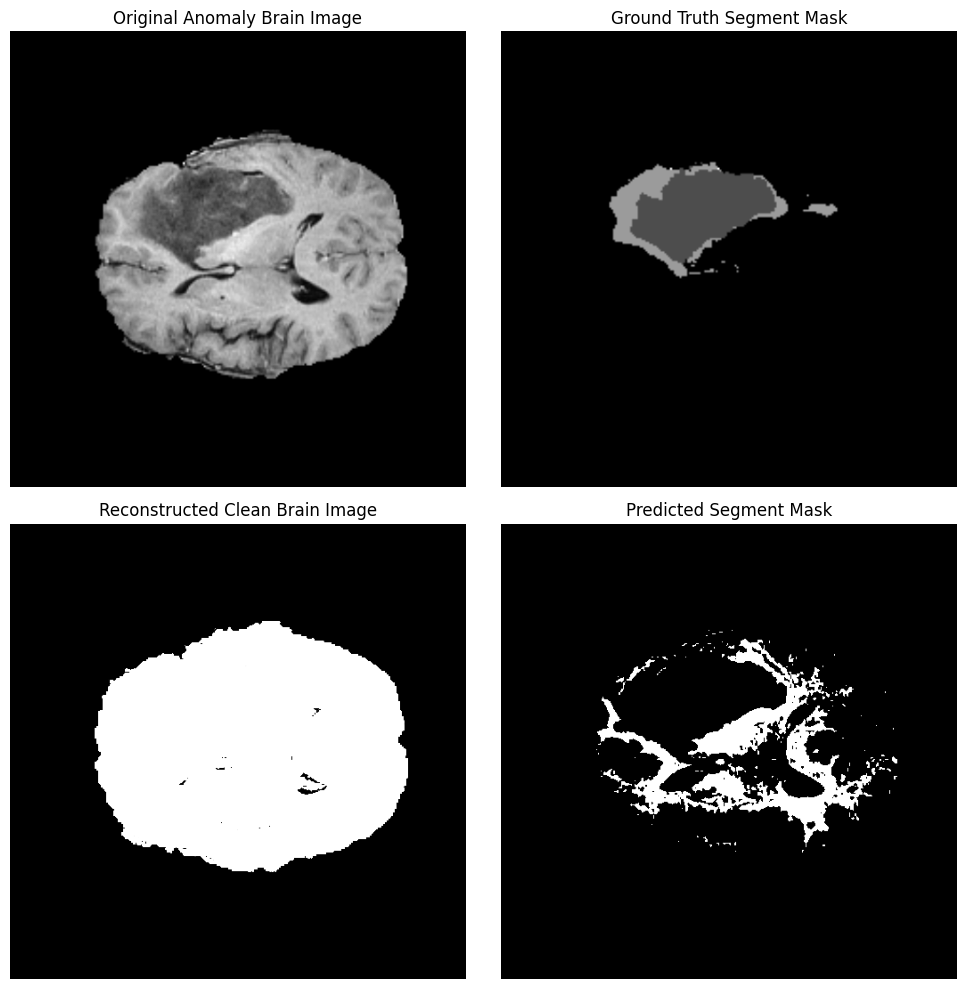

In [6]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import jaccard_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.image import ssim

def ssim_metric(y_true, y_pred):
    return tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
# Load the trained model
unet_model = tf.keras.models.load_model(r"C:\Users\priya\Documents\DL project\autoencoder_epoch_900.h5",custom_objects={"custom_loss":custom_loss})

# Load the anomaly brain image and the segmentation mask
anomaly_image_path = r"C:\Users\priya\Documents\DL project\test\processed_image.png"  # Replace with your actual path
segment_mask_path = r"C:\Users\priya\Documents\DL project\test\processed_mask.png"  # Replace with your actual path

# Load images
anomaly_image = cv2.imread(anomaly_image_path, cv2.IMREAD_GRAYSCALE)
segment_mask = cv2.imread(segment_mask_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the anomaly image: expand dimensions to fit the model's input shape (batch size, height, width, channels)
anomaly_image_exp = np.expand_dims(anomaly_image, axis=(0, -1))  # Add batch and channel dimensions

# Ensure the segmentation mask is binary (threshold to create binary mask)
#segment_mask = (segment_mask > 0).astype(np.uint8)

# Predict the clean brain image by reconstructing the anomaly image
reconstructed_image = unet_model.predict(anomaly_image_exp)
reconstructed_image = np.squeeze(reconstructed_image)  # Remove batch dimension for visualization

# Difference between the original (anomaly) and reconstructed image
predicted_diff = np.abs(anomaly_image - reconstructed_image)

# Threshold the difference to get a binary mask for predicted anomaly
threshold = 0.7 * np.max(predicted_diff)  # Adjust based on sensitivity
predicted_segment = (predicted_diff > threshold).astype(np.uint8)

# Flatten both the predicted mask and the ground truth mask for metric calculation
predicted_segment_flat = predicted_segment.flatten()
segment_mask_flat = segment_mask.flatten()

# Compute the Intersection over Union (IoU) or Jaccard Index
iou = jaccard_score(segment_mask_flat, predicted_segment_flat, average=None)

# Compute Dice coefficient (F1 score for binary segmentation)
dice = f1_score(segment_mask_flat, predicted_segment_flat, average=None)

# Print evaluation metrics
print(f"IoU (Jaccard Index): {iou}")
print(f"Dice Coefficient: {dice}")

# Visualize the original image, segment mask, reconstructed image, and predicted segment area
plt.figure(figsize=(10, 10))

# Display the original anomaly brain image
plt.subplot(2, 2, 1)
plt.imshow(anomaly_image, cmap='gray')
plt.title('Original Anomaly Brain Image')
plt.axis('off')

# Display the ground truth segmentation mask
plt.subplot(2, 2, 2)
plt.imshow(segment_mask, cmap='gray')
plt.title('Ground Truth Segment Mask')
plt.axis('off')

# Display the reconstructed brain image (model output)
plt.subplot(2, 2, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Clean Brain Image')
plt.axis('off')

# Display the predicted segment mask from the difference
plt.subplot(2, 2, 4)
plt.imshow(predicted_segment, cmap='gray')
plt.title('Predicted Segment Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
